In [1]:
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchinfo
import torchvision
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.datasets.images import ImagePairDataset
from torchlake.common.models import VggFeatureExtractor
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import (color_histogram_matching, load_image,
                                          luminance_transfer,
                                          yiq_inverse_transform, yiq_transform)
from torchlake.common.utils.plot import plot_grids
from torchlake.style_transfer.models import AdaInTrainer
from torchlake.style_transfer.models.adain.loss import AdaInLoss
from torchlake.style_transfer.models.adain.network import AdaIn2d
from tqdm import tqdm

In [2]:
torch.__version__

'2.1.0+cu118'

In [3]:
torchvision.__version__

'0.16.0+cu118'

In [4]:
cv2.__version__

'4.8.1'

# Setting

In [5]:
artifacts_path = Path('../../artifacts/adain')
content_path = Path('../../data/coco')
style_path = Path('../../data/styles')

In [6]:
device = torch.device("cuda:0")

In [7]:
image_size = 256
longest_side = 512
batch_size = 8

# Dataset

In [8]:
transform = A.Compose([
    A.HorizontalFlip(),
    A.augmentations.geometric.resize.SmallestMaxSize(longest_side),
    A.RandomResizedCrop(image_size, image_size),
    A.Normalize(0, 1),
    ToTensorV2(),
])

In [9]:
dataset = ImagePairDataset(content_path.as_posix(), style_path.as_posix(), transform)

In [10]:
len(dataset)

123287

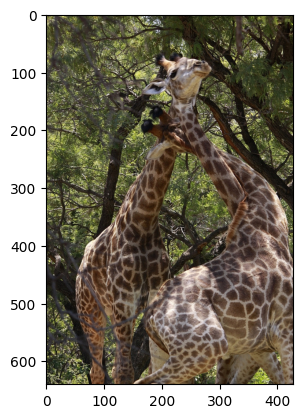

In [11]:
plt.imshow(dataset.get_content_img(10)[0])

In [12]:
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=4,
)

# Model

In [13]:
STYLE_LAYER_NAMES = ['1_1', '2_1', '3_1', '4_1']

In [14]:
feature_extractor = VggFeatureExtractor('vgg19', 'relu')

In [15]:
model = AdaInTrainer(feature_extractor, STYLE_LAYER_NAMES).to(device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
AdaInTrainer                                  --
├─FeatureExtractor: 1-1                       --
│    └─ImageNormalization: 2-1                --
│    └─Sequential: 2-2                        --
│    │    └─Conv2d: 3-1                       1,792
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       36,928
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       73,856
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       147,584
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      295,168
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      590,080
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15              

# Training

In [17]:
EPOCHS = 1
LR = 1e-4

In [18]:
criterion = AdaInLoss(lambda_coef=5)
optimizer = torch.optim.Adam(model.decoder.parameters(), lr=LR)

In [19]:
for e in range(EPOCHS):
    running_loss = 0
    running_closs = 0
    running_sloss = 0

    for content, style in tqdm(loader):
        optimizer.zero_grad()

        content = content.to(device)
        style = style.to(device)

        ouput = model.loss_forward(content, style)
        loss, c_loss, s_loss = criterion(*ouput)

        if torch.isnan(loss):
            print(loss.item())
            raise ValueError("loss died")
        else:
            loss.backward()
            running_loss += loss.item()
            running_closs += c_loss.item()
            running_sloss += s_loss.item()

        optimizer.step()

    print(
        f"epoch {e+1}:",
        running_loss / len(dataset),
        running_closs / len(dataset),
        running_sloss / len(dataset),
    )

    # in case of crash
    torch.save(model, artifacts_path.joinpath(f"adain.{e+1}.pth").as_posix())

100%|██████████| 15410/15410 [2:26:05<00:00,  1.76it/s] 


epoch 1: 3.0056345457713047 1.7177318144549687 0.25758054593277224


In [18]:
model_path = artifacts_path / 'adain.pth'

In [21]:
torch.save(model.state_dict(), model_path.as_posix())

In [ ]:
model.load_state_dict(torch.load(model_path.as_posix()))

In [23]:
!du -sh adain.1.pth

90M	adain.1.pth


In [17]:
model.load_state_dict(torch.load(artifacts_path.joinpath('adain.coco.pth').as_posix()))

<All keys matched successfully>

# Inference

In [18]:
transform_test = A.Compose([
    # A.augmentations.geometric.resize.SmallestMaxSize(512),
    # A.RandomResizedCrop(512, 512),
    A.Resize(512, 512),
    A.Normalize(0, 1),
    ToTensorV2(),
])

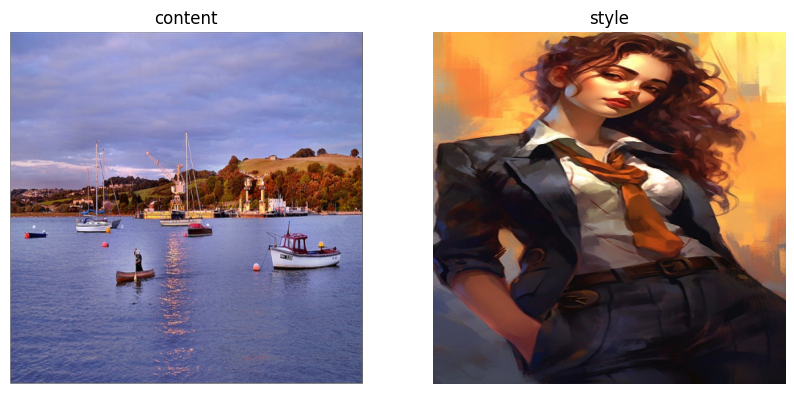

In [19]:
dataset_test = ImagePairDataset(
    content_path.as_posix(),
    style_path.as_posix(),
    transform_test,
)

# random_idx = random.randint(0, len(dataset_test) - 1 )
# print(random_idx)
# content, style = dataset_test[random_idx]

content = transform_test(image=dataset_test.get_content_img(63485)[0])["image"]

style_img_path = (
    style_path
    / "10 Pop Stars Of The Early 2000’s If They Were Dolls, Made With Ai (13 Pics).jpg"
)
style = transform_test(image=load_image(style_img_path, is_numpy=True))["image"]

plot_grids(
    [img_tensor_to_np(content), img_tensor_to_np(style)],
    ["content", "style"],
    1,
    2,
    figsize=(10, 10),
)

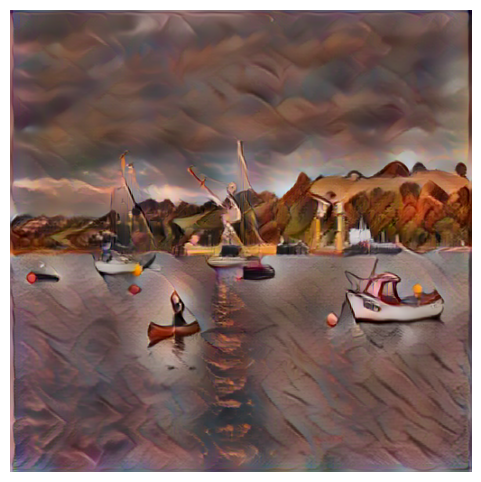

In [29]:
# n = 30000, lambda = 5
model.eval()
with torch.no_grad():
    generated_chm = model(content.unsqueeze(0).to(device), style.unsqueeze(0).to(device))
    plot_grids([img_tensor_to_np(generated_chm.clip(0, 1))], figsize=(6, 6))

## style weighting

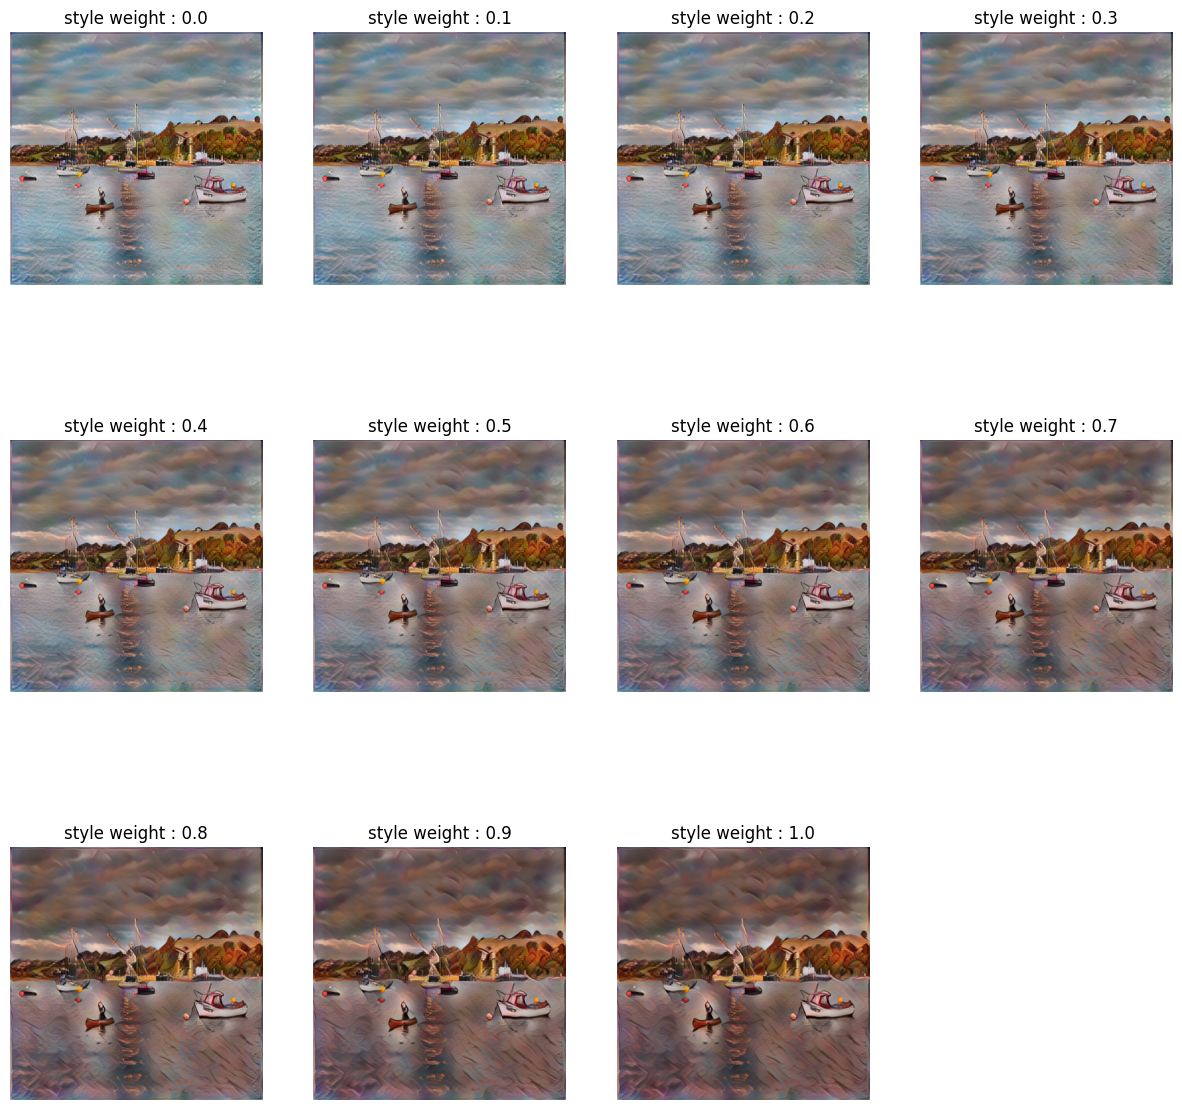

In [39]:
model.eval()
with torch.no_grad():
  plt.figure(figsize=(15, 15))
  for i, weight in enumerate(np.arange(0, 1.1, 0.1)):
    weight = weight.round(1)
    generated_chm = model(content.unsqueeze(0).to(device), style.unsqueeze(0).to(device), alpha=weight)
    plt.subplot(3, 4, i+1)
    plt.axis('off')
    plt.title(f'style weight : {weight}')
    plt.imshow(img_tensor_to_np(generated_chm.clip(0, 1)))

## Style interpolation

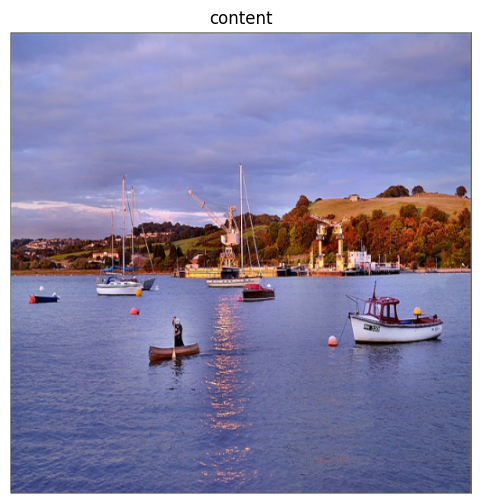

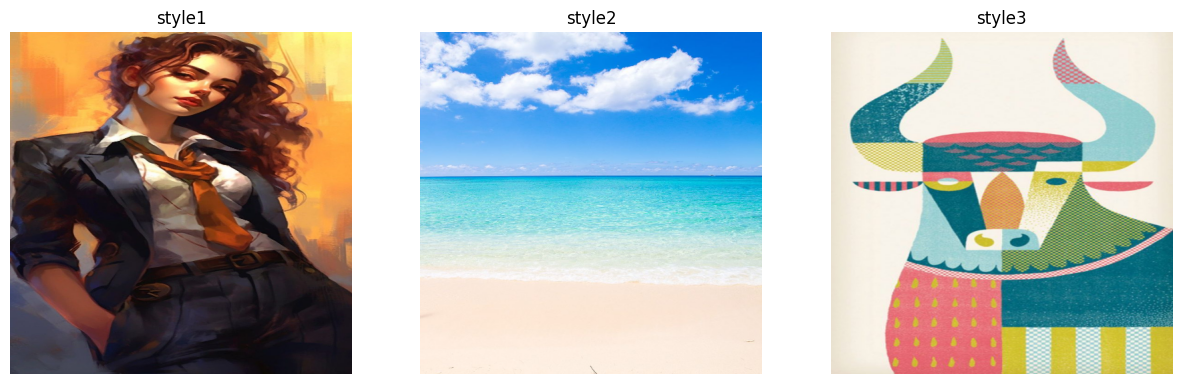

In [20]:
# content_1, style_1 = dataset_test[random.randint(0, len(dataset_test)-1)]
# style_2 = transform_test(image=dataset_test.get_style_img()[0])['image']
# style_3 = transform_test(image=dataset_test.get_style_img()[0])['image']
style_2 = transform_test(
    image=load_image(
        style_path / "A Memorable 6 Day Western Caribbean Cruise On Carnival Vista.jpg",
        is_numpy=True,
    )
)["image"]
style_3 = transform_test(
    image=load_image(
        style_path / "Ox Painting Project for Kids - 2021 Year of the Ox.jpg",
        is_numpy=True,
    )
)["image"]


plot_grids(
    [img_tensor_to_np(content)],
    ["content"],
    1,
    1,
    figsize=(8, 6),
)
plot_grids(
    [
        img_tensor_to_np(style),
        img_tensor_to_np(style_2),
        img_tensor_to_np(style_3),
    ],
    ["style1", "style2", "style3"],
    1,
    3,
    figsize=(15, 15),
)

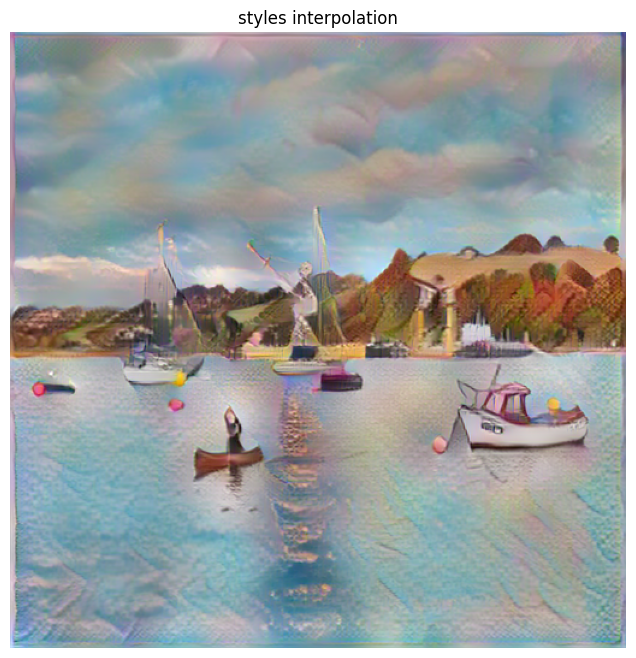

In [47]:
weights = np.array([0.33, 0.33, 0.33])
weights /= sum(weights)

generated_chm = model.style_interpolation_forward(
    content.unsqueeze(0).to(device), 
    torch.stack([style, style_2, style_3]).to(device), 
    weights,
)

plot_grids(
    [img_tensor_to_np(generated_chm.clip(0, 1))],
    ["styles interpolation"],
    1,
    1,
)

## space preservation

In [ ]:
# data/coco/train2017/000000312790.jpg

In [ ]:
# masked = np.where(upper_mask < 255, 0, upper_mask)
# total = (masked > 0).sum(2, keepdims=True)
# total = np.where(np.logical_and(total > 0, total < 3), 255, masked)
# cv2.imwrite('a.jpg', total)

True

In [21]:
transform_mask = A.Compose([
    A.Resize(512, 512),
    A.Normalize(0,1),
    ToTensorV2(),
])

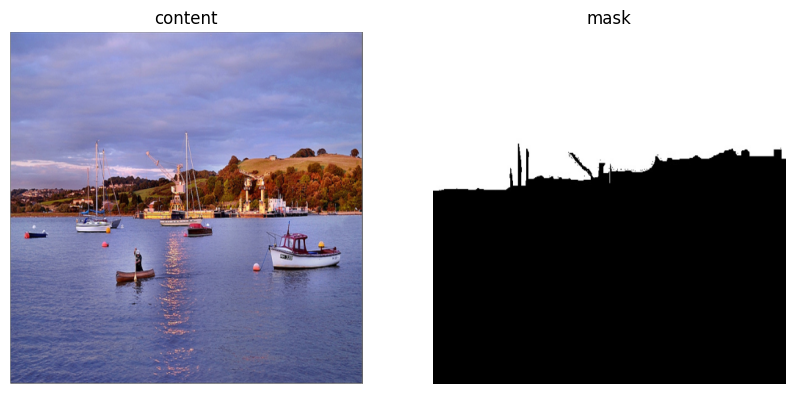

In [22]:
upper_mask = transform_mask(image=load_image(artifacts_path / 'upper_mask.jpg', is_numpy=True))['image']

plot_grids(
    [img_tensor_to_np(content), img_tensor_to_np(upper_mask)],
    ["content", "mask"],
    1,
    2,
    figsize=(10, 10),
)

In [23]:
c_input = content.unsqueeze(0).to(device)
s_input = style.unsqueeze(0).to(device)
s2_input = style_2.unsqueeze(0).to(device)
m_input = upper_mask.unsqueeze(0).to(device)

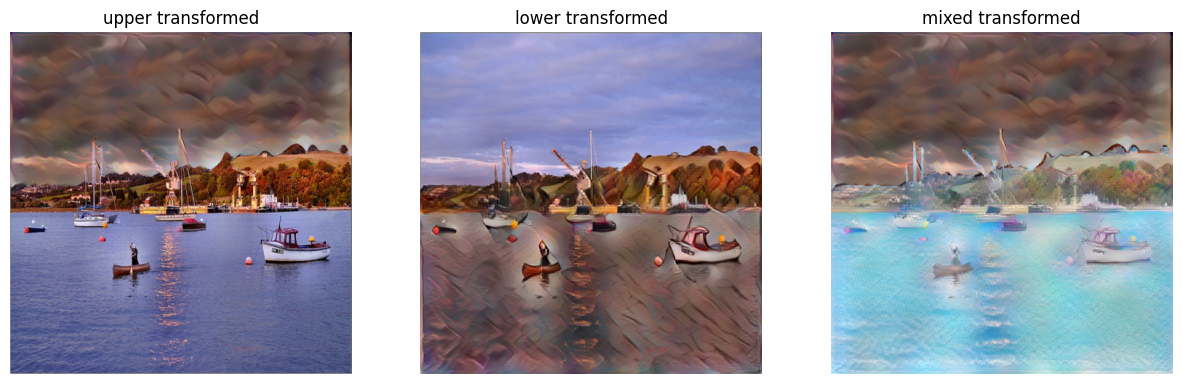

In [24]:
generated = model(c_input, s_input)
generated2 = model(c_input, s2_input)

lower_preserved = generated * m_input + c_input * (1 - m_input)
upper_preserved = generated * (1 - m_input) + c_input * m_input
mixed_preserved = generated * m_input + generated2 * (1 - m_input)

plot_grids(
    [
        img_tensor_to_np(lower_preserved.clip(0, 1)),
        img_tensor_to_np(upper_preserved.clip(0, 1)),
        img_tensor_to_np(mixed_preserved.clip(0, 1)),
    ],
    ["upper transformed", "lower transformed", "mixed transformed"],
    1,
    3,
    figsize=(15, 15),
)

## color preservation

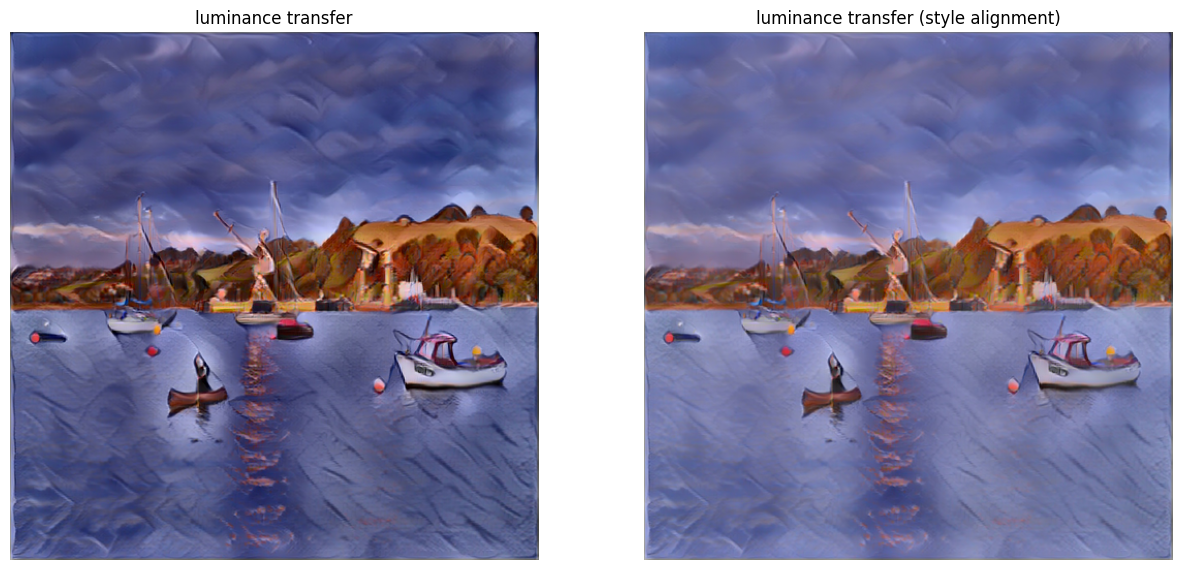

In [26]:
# luminance transfer
luminance_transferred = luminance_transfer(generated, c_input)

# standardization alignment
content_yiq = yiq_transform(c_input)
style_yiq = yiq_transform(s_input)
normalization = AdaIn2d(style_yiq[:, 0:1, :, :], content_yiq[:, 0:1, :, :])
style_yiq[:, 0:1, :, :] = normalization(style_yiq[:, 0:1, :, :])
style_yiq_align = yiq_inverse_transform(style_yiq)

generated_style_align = model(c_input, style_yiq_align.to(device))

luminance_transfer_style_align = luminance_transfer(generated_style_align, c_input)

plot_grids(
    [
        img_tensor_to_np(luminance_transferred.clip(0, 1)),
        img_tensor_to_np(luminance_transfer_style_align.clip(0, 1)),
    ],
    ["luminance transfer", "luminance transfer (style alignment)"],
    1,
    2,
    figsize=(15, 15),
)

tensor([[[ 0.4222, -0.1033,  0.1641],
         [-0.0779,  0.3281,  0.6246],
         [-0.0765, -0.3084,  1.9960]]], device='cuda:0')


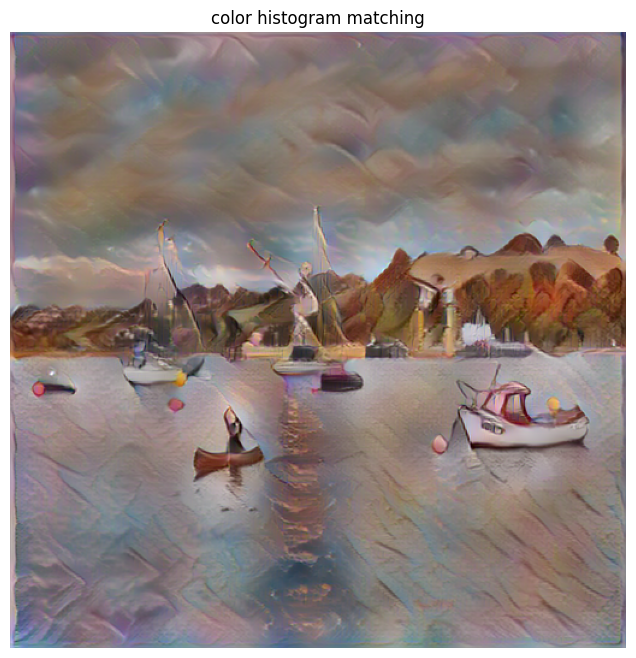

In [28]:
chm = color_histogram_matching(c_input, s_input)
generated_chm = model(c_input, chm)

plot_grids(
    [img_tensor_to_np(generated_chm.clip(0, 1))],
    ["color histogram matching"],
    1,
    1,
    figsize=(8, 8),
)